In [1]:
# IMPORT REQUIRED LIBRARIES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from abess import LinearRegression as ABESS_LR # Adaptive BEst Subset Selection
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from models import PCR, SPCA_LR, SFS_LR, SFS_QR 

SEED = 9

In [2]:
# IMPORT PROCESSED DATA

abs_df = pd.read_csv("C:\\Users\\argan\\OneDrive\\Desktop\\DDP\\Final Data\\TurkishAbs.csv", index_col=0)

wavelengths = abs_df.iloc[:, :-1].columns

In [3]:
abs_df.drop('Name', axis=1, inplace=True)

abs_df = abs_df.groupby(['Group']).mean()

abs_df = abs_df.reset_index(drop=True)


### Removing Outliers - Visual Inspection (EDA)

Scatter plot of Absorbance Value at 485 nm v/s Brix Values - Outlier has highest Brix value.

In [4]:
abs_df = abs_df[abs_df['Brix Values'] < 15.5]

abs_df = abs_df.reset_index(drop=True)

## Latent Variable Models

### PLSR

In [5]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, 8+1, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, 8+1):

    regressor = PLSRegression(n_components=i)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                X, y,
                                scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                cv=kf,
                                n_jobs=-1, 
                                verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

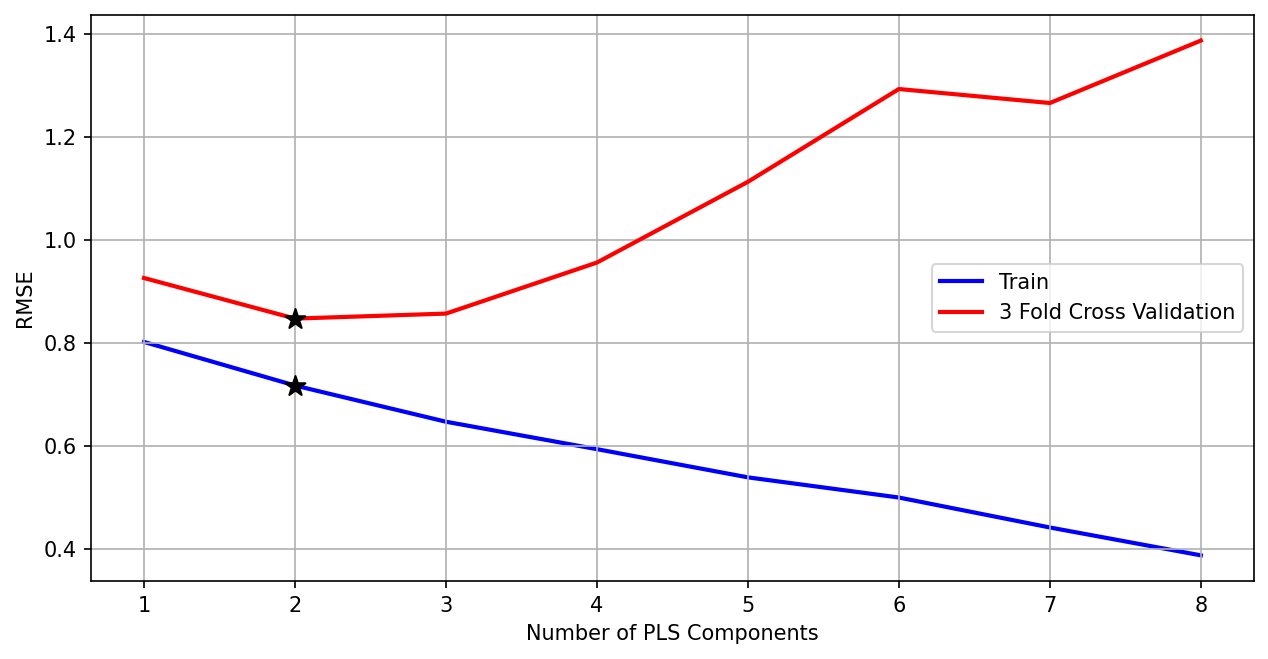

In [6]:
# Plot grid search results

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[1], train_rmse[1], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[1], cv_rmse[1], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of PLS Components")
plt.ylabel("RMSE")

plt.legend(loc='center right')
plt.grid()
plt.show()

In [7]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = PLSRegression(n_components=2)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 0.7169246827964137
MAE: 0.7878594117883402
R2 Score: 0.6291609899897956

VALIDATION: -
RMSE: 0.846948294091748, Standard Deviation: 0.24278887014398437
MAE: 0.7124266988567328, Standard Deviation: 0.13010554912950203
R2 Score: 0.4304177975440964, Standard Deviation: 0.1279627715863623


Residual Analysis

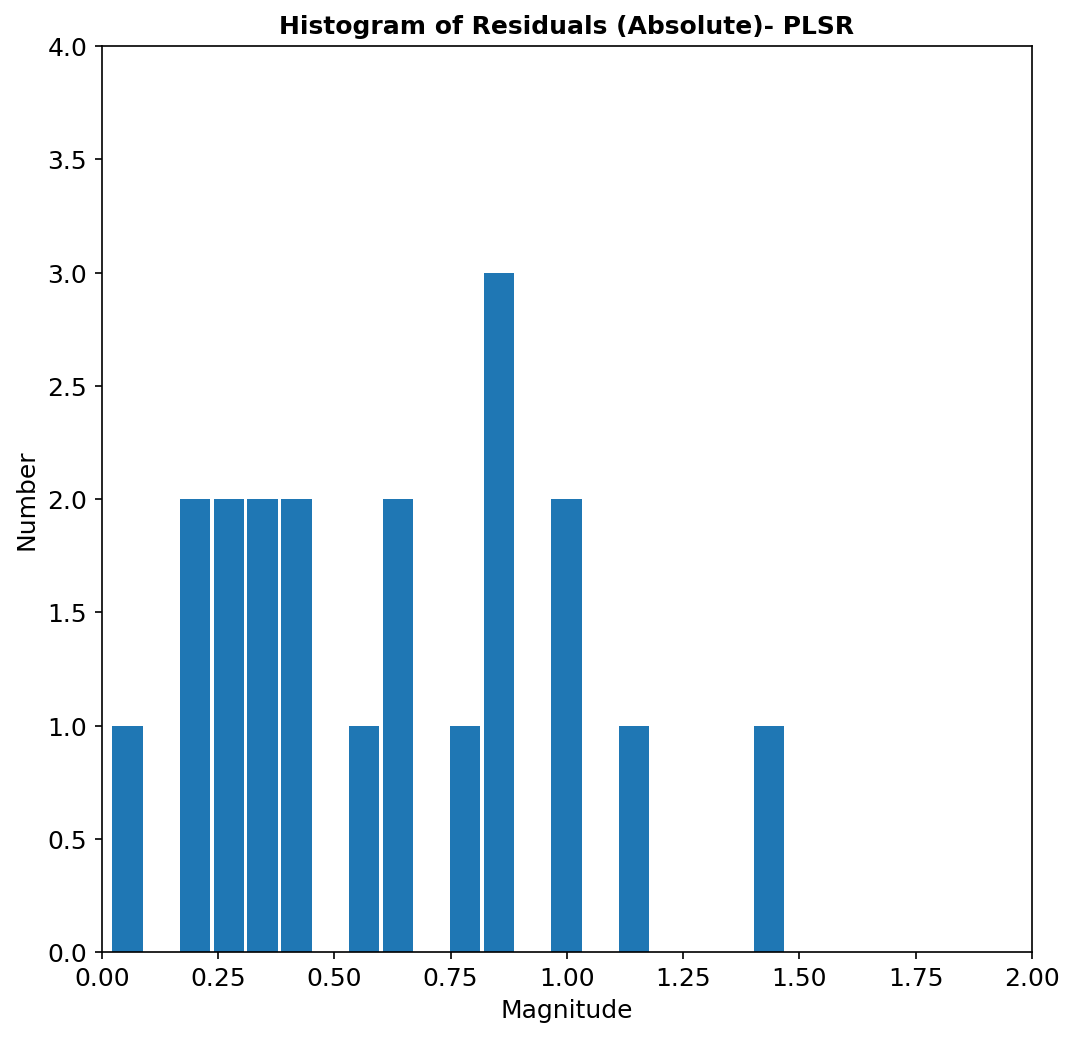

In [8]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(0, 2)
plt.ylim(0, 4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- PLSR", fontsize=12, fontweight='bold')
plt.show()

### PCR

In [9]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, 8+1, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, 8+1):

    regressor = PCR(n_components=i)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                X, y,
                                scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                cv=kf,
                                n_jobs=-1, 
                                verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

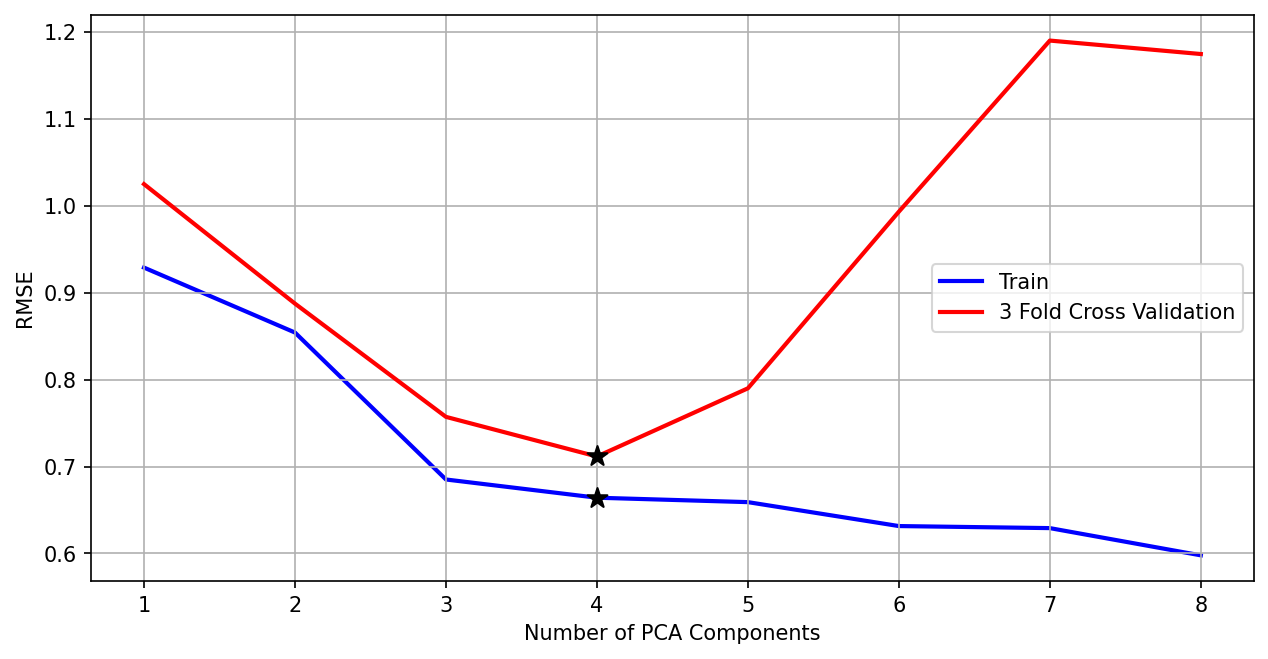

In [10]:
# Plot grid search results

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[3], train_rmse[3], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[3], cv_rmse[3], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of PCA Components")
plt.ylabel("RMSE")

plt.legend(loc='center right')
plt.grid()
plt.show()

In [11]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = PCR(n_components=4)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 0.6641512518196073
MAE: 0.754344522262221
R2 Score: 0.6817471229376739

VALIDATION: -
RMSE: 0.711545160735066, Standard Deviation: 0.18290420079748237
MAE: 0.6243812686156147, Standard Deviation: 0.16415860378035022
R2 Score: 0.5966091226085962, Standard Deviation: 0.11863720580335442


Residual Analysis

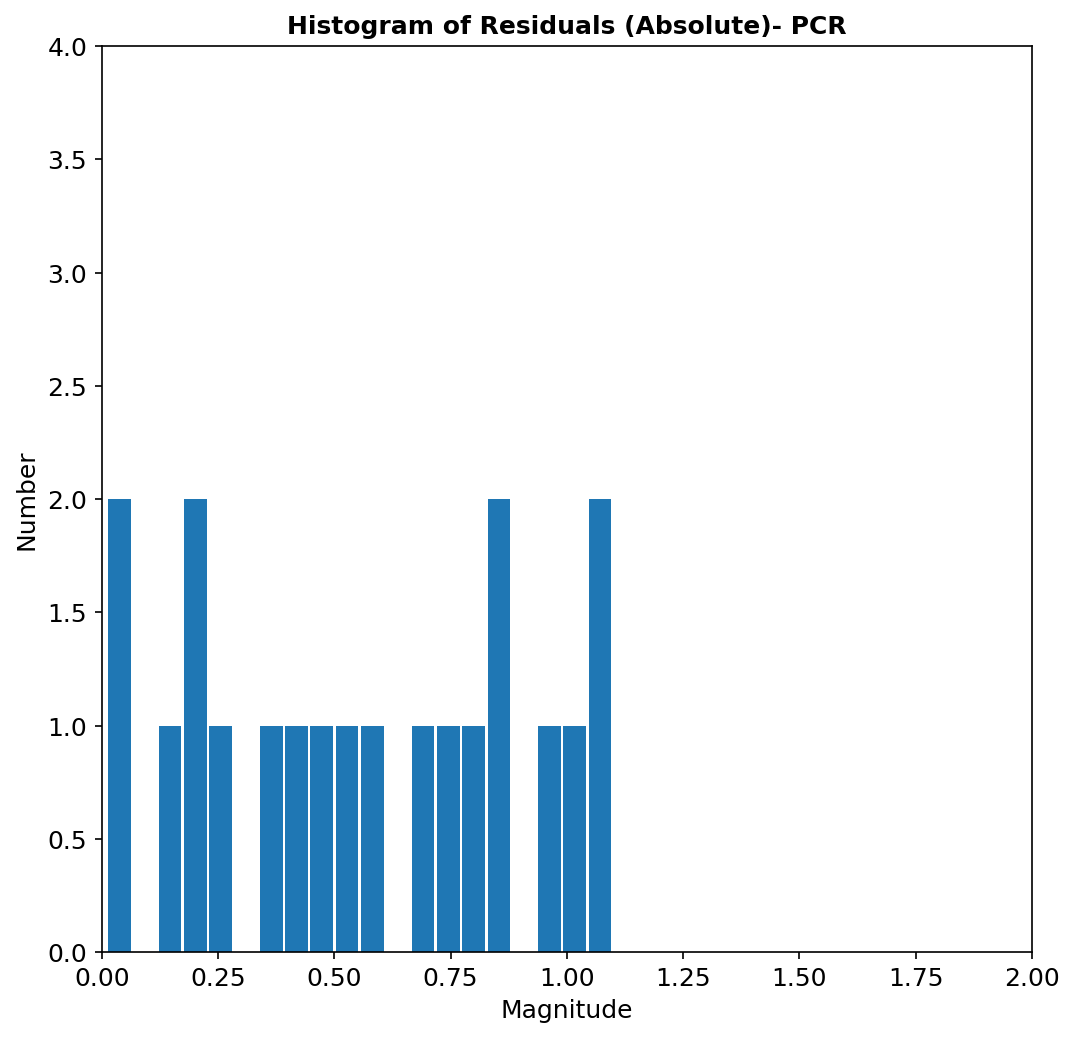

In [12]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(0, 2.0)
plt.ylim(0, 4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- PCR", fontsize=12, fontweight='bold')
plt.show()

### SPCA LR

In [13]:
# Grid Search

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

n_fs = np.arange(1, 8+1)

model_rmse = []

for n in n_fs:
    n_rmse = []
    for a in range(1, n+1):
        m = SPCA_LR(top_n=n, pca_components=a)

        kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                                
        val_metrics = cross_validate(m,
                                     X, y,
                                     scoring=["neg_mean_squared_error"],
                                     cv=kf,
                                     n_jobs=-1, 
                                     verbose=0)
        
        n_rmse.append(np.sqrt(np.mean(-val_metrics["test_neg_mean_squared_error"])))
    
    model_rmse.append(n_rmse)

In [14]:
min_n_rmse = [min(model_rmse[i]) for i in range(len(model_rmse))]

top_n = np.argmin(min_n_rmse)+1

pca_components = np.argmin(model_rmse[top_n-1])+1

(top_n, pca_components)

(5, 3)

In [15]:
# Grid Search 2 - Redundant - Plotting purpose

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

components = np.arange(1, 5+1, 1)

train_rmse = np.zeros(len(components))

cv_rmse = np.zeros(len(components))
cv_rmse_std = np.zeros(len(components))

for i in range(1, 5+1):

    regressor = SPCA_LR(top_n=5, pca_components=i)

    regressor.fit(X, y)

    y_pred = regressor.predict(X).squeeze()

    rmse_train = np.sqrt(mean_squared_error(y, y_pred))

    # Calculate Cross-Validation Metrics
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                            
    val_metrics = cross_validate(regressor,
                                X, y,
                                scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                                cv=kf,
                                n_jobs=-1, 
                                verbose=0)
    
    rmse_cv = np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error']))
    rmse_std_cv = np.std(-val_metrics['test_neg_mean_squared_error'])

    train_rmse[i-1] = rmse_train
    cv_rmse[i-1] = rmse_cv
    cv_rmse_std[i-1] = rmse_std_cv

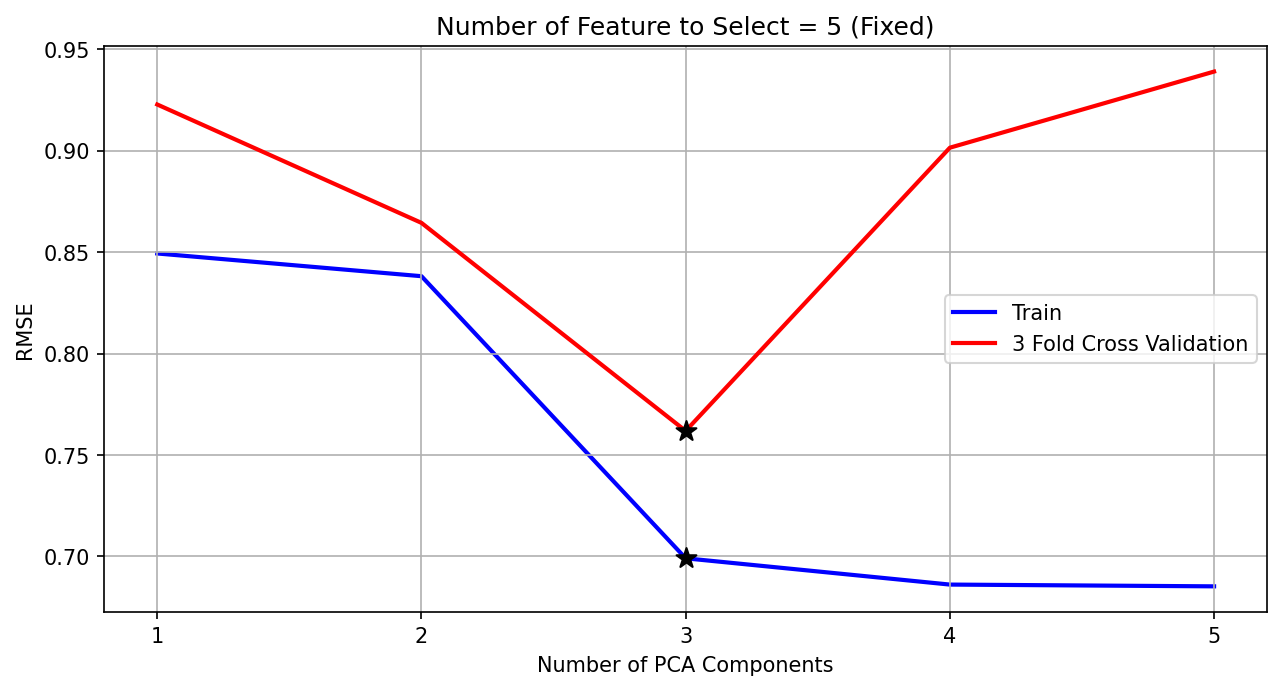

In [16]:
# Plot grid search 2 results

plt.figure(figsize=(10, 5), dpi=150)

plt.plot(components, train_rmse, c='b', lw=2, label="Train", zorder=1)
plt.plot(components, cv_rmse, c='r', lw=2, label='3 Fold Cross Validation', zorder=2)

plt.scatter(components[2], train_rmse[2], c='k', s=100, marker='*', zorder=3)
plt.scatter(components[2], cv_rmse[2], c='k', s=100, marker='*', zorder=4)

plt.xticks(components)
plt.xlabel("Number of PCA Components")
plt.ylabel("RMSE")
plt.title("Number of Feature to Select = 5 (Fixed)")

plt.legend(loc='center right')
plt.grid()
plt.show()

In [17]:
# Train and validate on optimal hyperparameters.

X, y = abs_df.values[:, :-1], abs_df['Brix Values'].values

regressor = SPCA_LR(top_n=top_n, pca_components=pca_components)

regressor.fit(X, y)

y_pred = regressor.predict(X).squeeze()

# Calculate Standardized Residuals
std = np.std(y.squeeze()-y_pred.squeeze())

res = (y.squeeze()-y_pred.squeeze())/std

# Calculate Validation Metrics
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
                         
val_metrics = cross_validate(regressor,
                             X, y,
                             scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], 
                             cv=kf,
                             n_jobs=-1, 
                             verbose=0)

print("TRAINING: -")
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
print("MAE:", np.sqrt(mean_absolute_error(y, y_pred)))
print("R2 Score:", r2_score(y, y_pred))
print()
print("VALIDATION: -")
print("RMSE:", np.sqrt(-np.mean(val_metrics['test_neg_mean_squared_error'])), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_squared_error']))
print("MAE:", -np.mean(val_metrics['test_neg_mean_absolute_error']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_neg_mean_absolute_error']))
print("R2 Score:", np.mean(val_metrics['test_r2']), end=", ")
print("Standard Deviation:", np.std(val_metrics['test_r2']))

TRAINING: -
RMSE: 0.6990523584748903
MAE: 0.7774448238077262
R2 Score: 0.6474199314343341

VALIDATION: -
RMSE: 0.7618743375636756, Standard Deviation: 0.23463642709891047
MAE: 0.6550394950952457, Standard Deviation: 0.17689481654125136
R2 Score: 0.5431355172791853, Standard Deviation: 0.13963406538339435


Residual Analysis

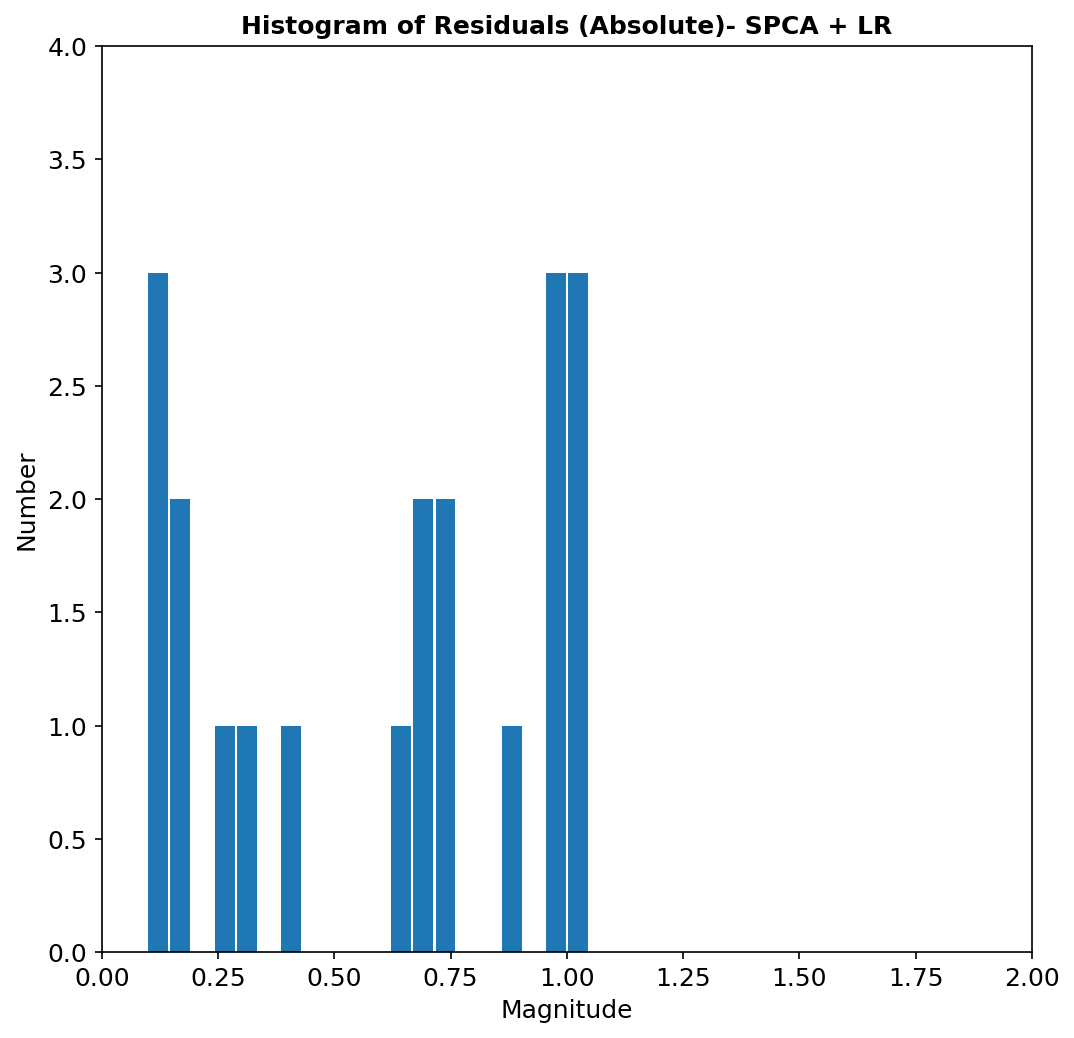

In [18]:
plt.figure(figsize=(8, 8), dpi=150)
plt.hist(np.abs(y-y_pred), bins=20, rwidth=0.9)
plt.xlim(0, 2)
plt.ylim(0, 4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Number", fontsize=12)

plt.title("Histogram of Residuals (Absolute)- SPCA + LR", fontsize=12, fontweight='bold')
plt.show()